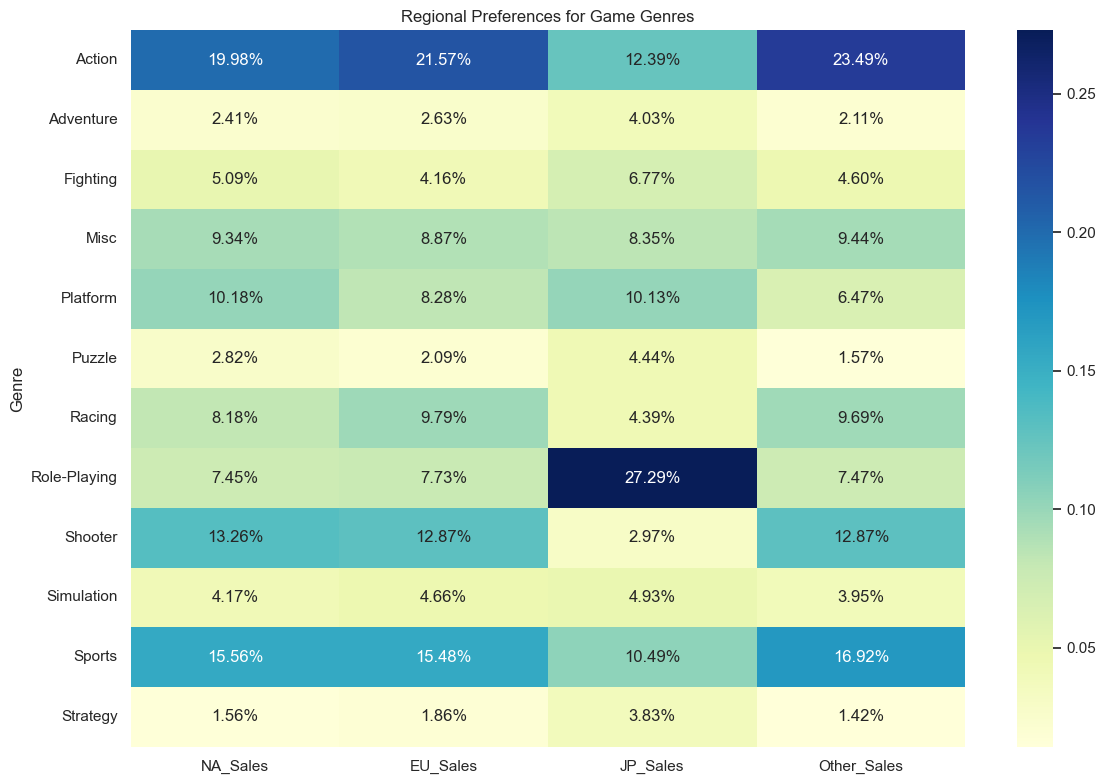

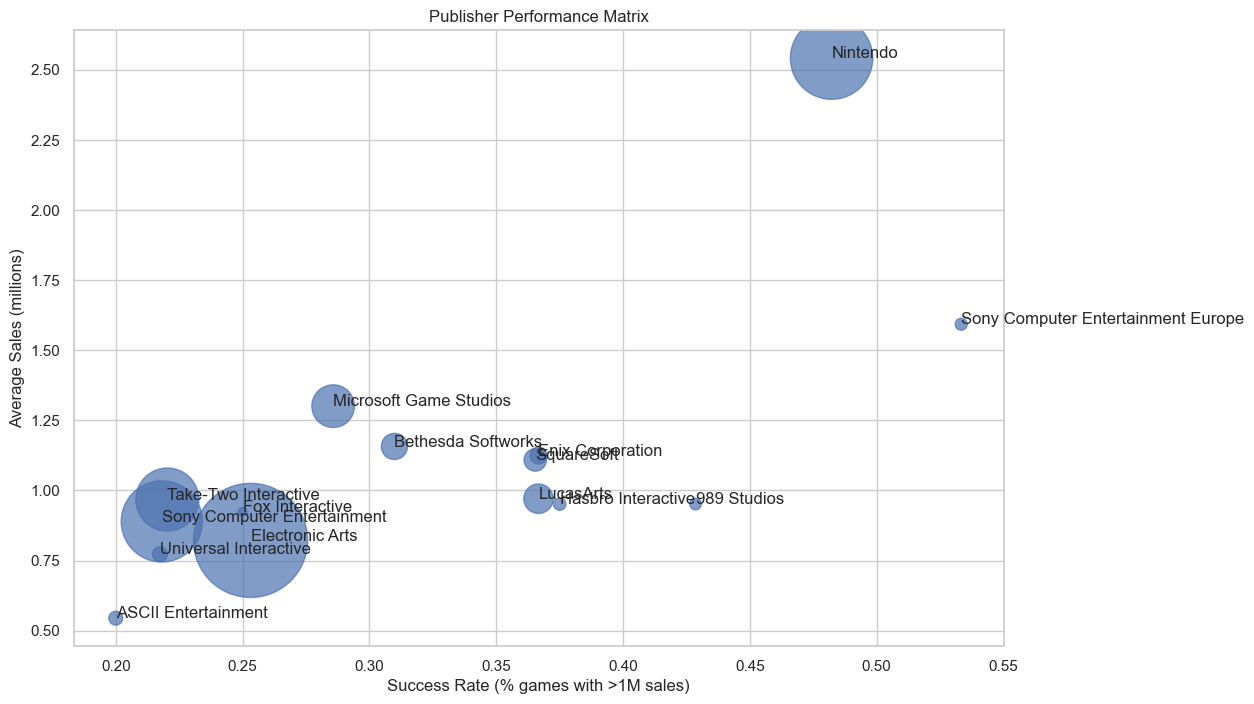

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('vgsales.csv')
# Make sure Year is treated as a categorical variable for better visualization
df['Year'] = df['Year'].astype('Int64')  # Handle potential NaN values

# 1. Genre Performance Analysis by Region

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")


# Create pivot table of genres vs regions
genre_region = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
    
# Normalize by region
normalized = genre_region.div(genre_region.sum())
    
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized, annot=True, cmap='YlGnBu', fmt='.2%')
plt.title('Regional Preferences for Game Genres')
plt.tight_layout()
plt.show()

# 2. Publisher Success Rate Analysis

# Define success threshold 
success_threshold = 1.0  # Defining games with ≥1M sales as successful

# Calculate success metrics
publisher_stats = df.groupby('Publisher').agg(
    total_games=('Name', 'count'),
    successful_games=('Global_Sales', lambda x: sum(x >= success_threshold)),
    total_sales=('Global_Sales', 'sum'),
    avg_sales=('Global_Sales', 'mean')
    )
publisher_stats['success_rate'] = publisher_stats['successful_games'] / publisher_stats['total_games']
    
# Plot top publishers (with at least 5 games)
top_publishers = publisher_stats[publisher_stats['total_games'] >= 5].sort_values('success_rate', ascending=False).head(15)
    
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    top_publishers['success_rate'], 
    top_publishers['avg_sales'],
    s=top_publishers['total_games'] * 5,
    alpha=0.7
)
    
for i, publisher in enumerate(top_publishers.index):
    ax.annotate(publisher, 
                (top_publishers['success_rate'].iloc[i], top_publishers['avg_sales'].iloc[i]))
    
plt.xlabel('Success Rate (% games with >1M sales)')
plt.ylabel('Average Sales (millions)')
plt.title('Publisher Performance Matrix')
plt.show()

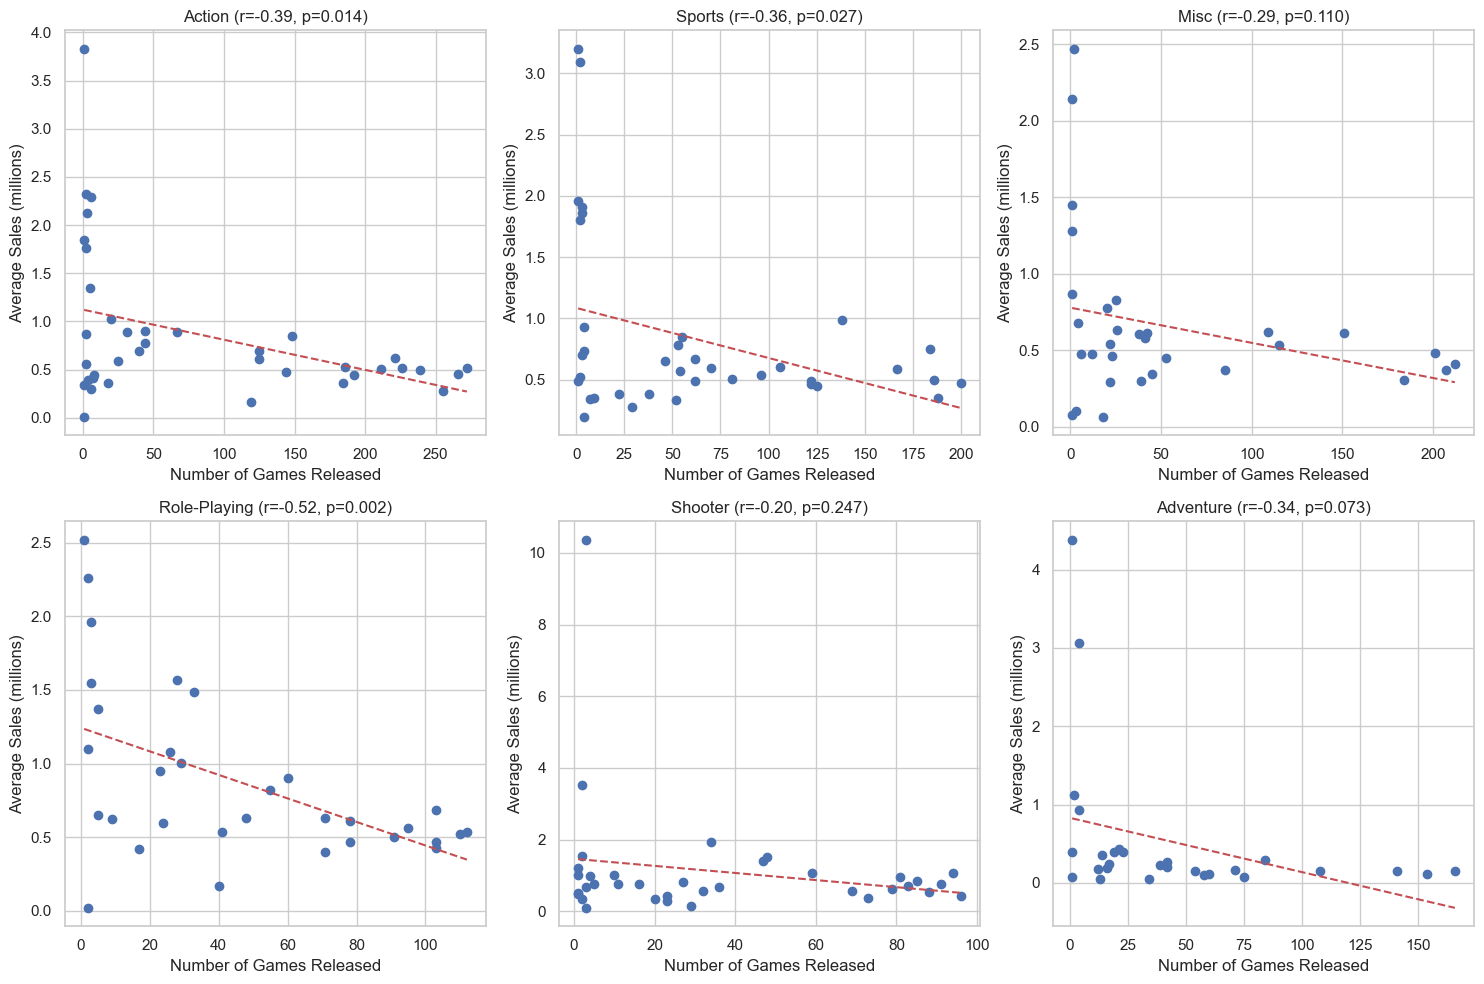

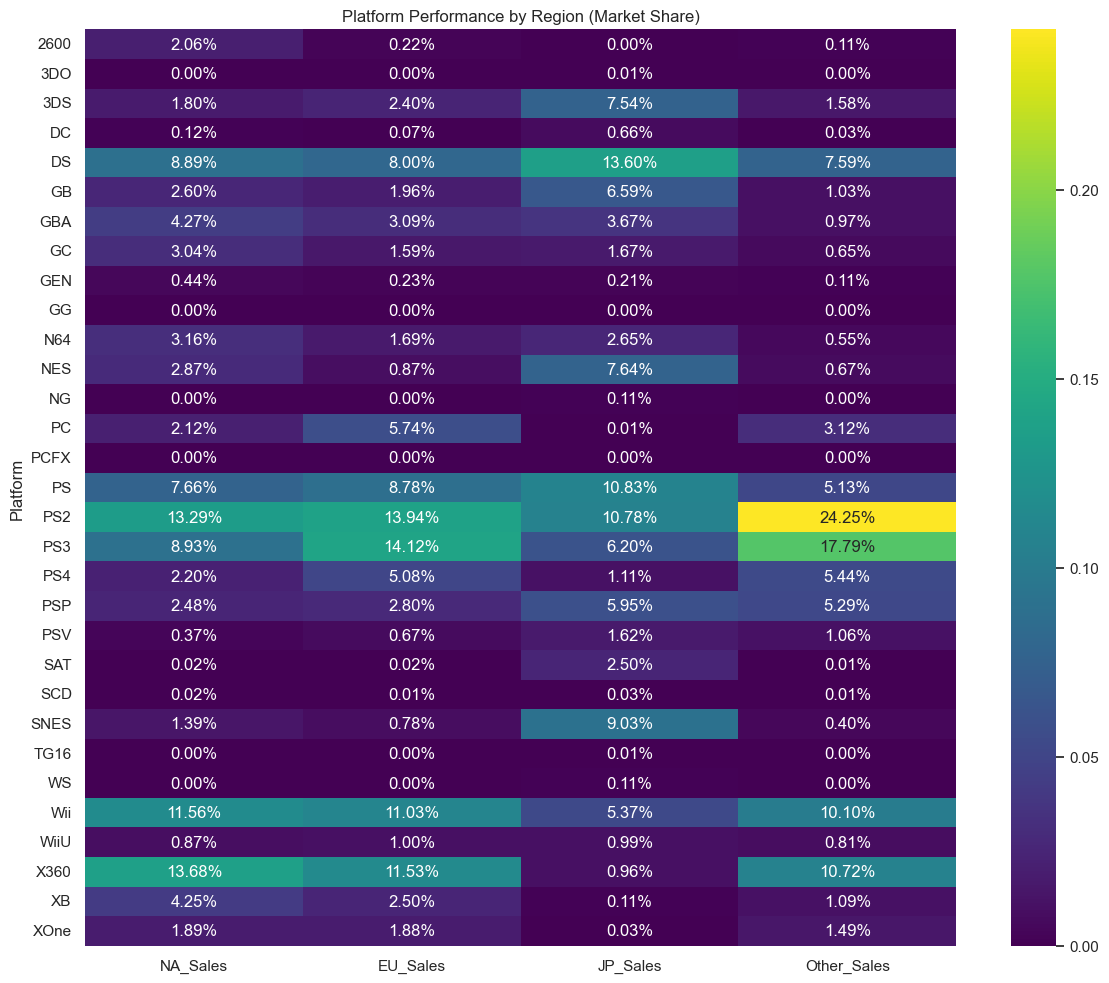

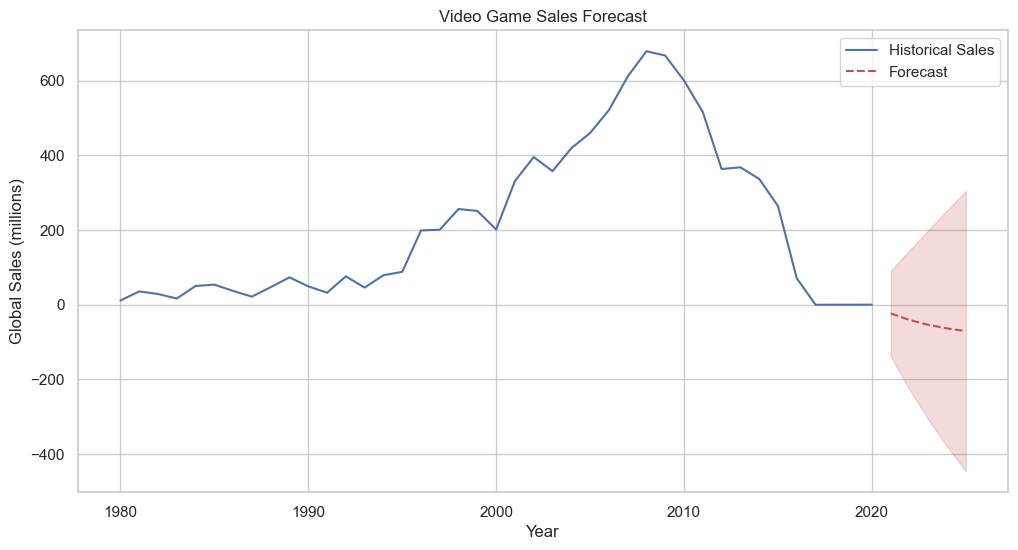

In [4]:
# 3. Market Saturation Analysis

# Group by Year and Genre
saturation = df.groupby(['Year', 'Genre']).agg(
    game_count=('Name', 'count'),
    avg_sales=('Global_Sales', 'mean')
).reset_index()

# Create subplots for top genres
top_genres = df.Genre.value_counts().head(6).index
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, genre in enumerate(top_genres):
    genre_data = saturation[saturation['Genre'] == genre]
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(genre_data['game_count'], genre_data['avg_sales'])
    
    # Regression line
    if len(genre_data) > 2:
        X = genre_data['game_count'].values.reshape(-1, 1)
        y = genre_data['avg_sales'].values
        model = LinearRegression().fit(X, y)
        x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        ax.plot(x_range, model.predict(x_range), 'r--')
        
        # Calculate correlation
        corr, p = stats.pearsonr(genre_data['game_count'], genre_data['avg_sales'])
        ax.set_title(f'{genre} (r={corr:.2f}, p={p:.3f})')
    else:
        ax.set_title(genre)
        
    ax.set_xlabel('Number of Games Released')
    ax.set_ylabel('Average Sales (millions)')

plt.tight_layout()
plt.show()

# 4. Regional Preference Heatmap

# Create platform vs region matrix
platform_region = df.groupby('Platform')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
    
# Normalize by region
normalized = platform_region.div(platform_region.sum())
    
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(normalized, annot=True, cmap='viridis', fmt='.2%')
plt.title('Platform Performance by Region (Market Share)')
plt.tight_layout()
plt.show()

# 5. Time Series Forecasting

# Aggregate yearly sales
yearly_sales = df.groupby('Year')['Global_Sales'].sum().reset_index()
yearly_sales = yearly_sales.sort_values('Year')
    
# Fit ARIMA model
model = sm.tsa.ARIMA(yearly_sales['Global_Sales'], order=(1,1,1))
results = model.fit()
    
# Forecast next 5 years
forecast_years = range(int(yearly_sales['Year'].max()) + 1, int(yearly_sales['Year'].max()) + 6)
forecast = results.forecast(steps=5)
    
# Get forecast confidence intervals
forecast_ci = results.get_forecast(steps=5).conf_int()
lower_ci = forecast_ci.iloc[:, 0]
upper_ci = forecast_ci.iloc[:, 1]
    
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Global_Sales'], 'b-', label='Historical Sales')
plt.plot(forecast_years, forecast, 'r--', label='Forecast')

# Use the properly sized confidence intervals
plt.fill_between(forecast_years, 
                lower_ci, 
                upper_ci, 
                color='r', alpha=0.2)
                
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Video Game Sales Forecast')
plt.legend()
plt.show()
    


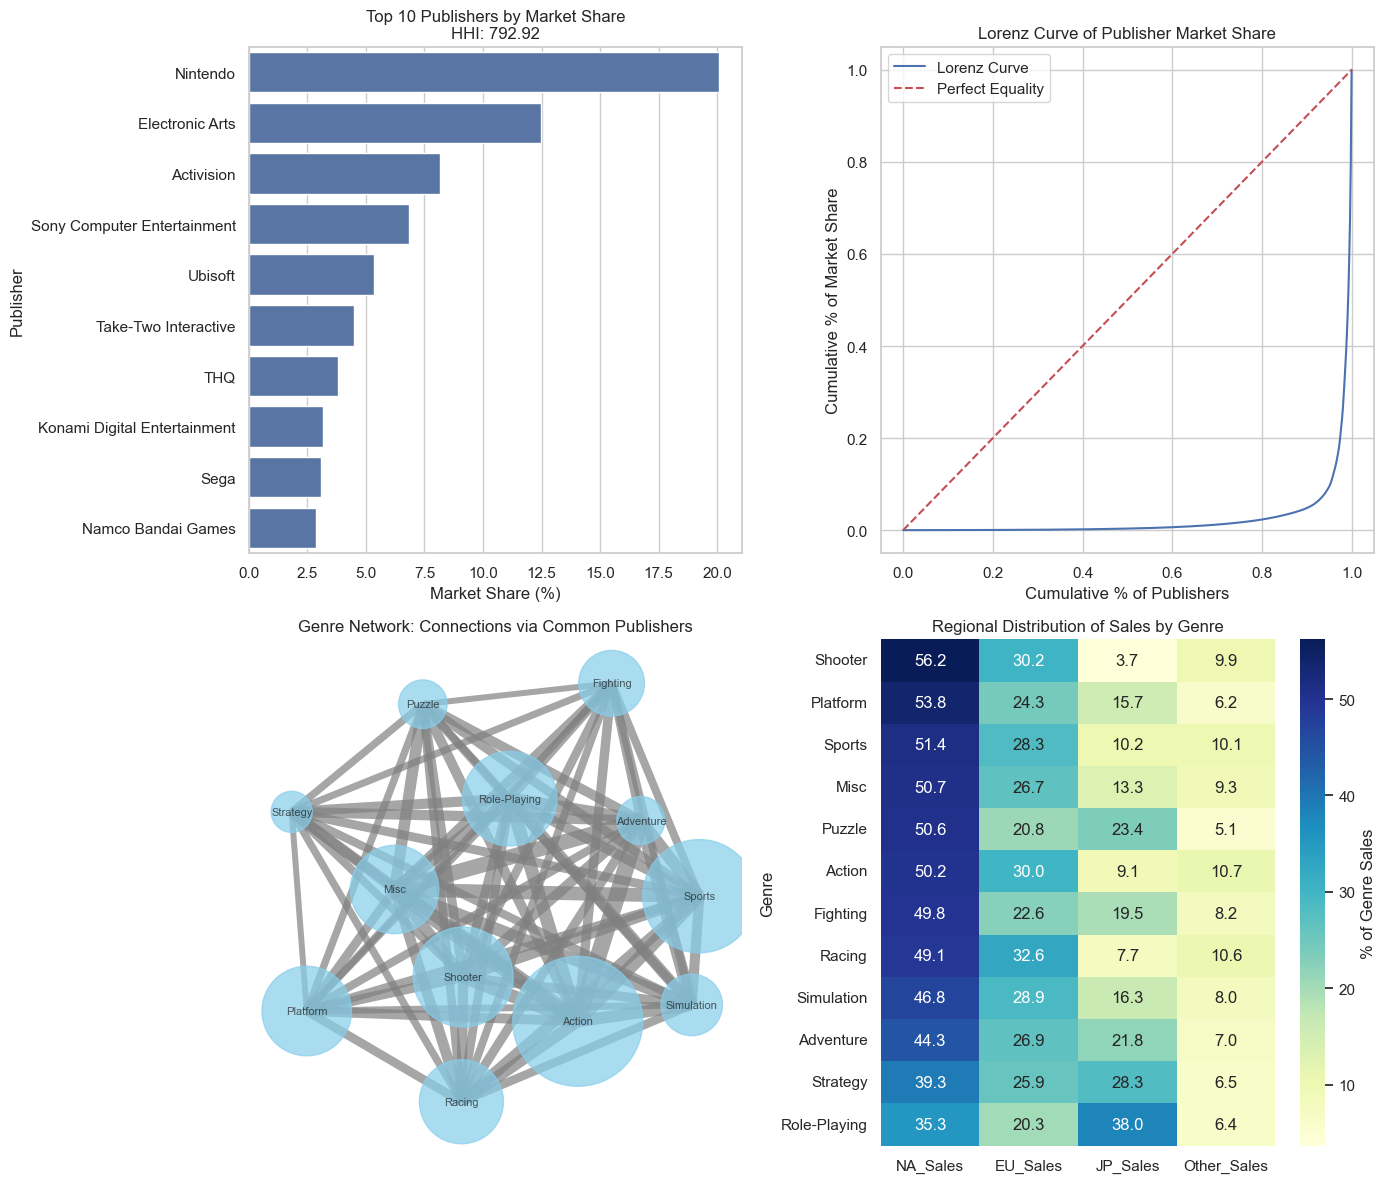

Market Concentration Analysis:
- HHI Index: 792.92 (>2500 is highly concentrated, 1500-2500 is moderately concentrated)
- Top publisher market share: Nintendo (20.06%)
- Top 5 publishers control 52.85% of the market

Genre Network Analysis:
- Most connected genre: Sports with 11 connections
- Strongest genre connection: Action — Adventure (shared by 119 publishers)
- Most versatile publisher: Nintendo with 12 genres


In [5]:
# 6. Market Concentration Analysis

# For reproducibility
np.random.seed(42)

# Calculate market share by publisher
publisher_sales = df.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)
total_sales = publisher_sales.sum()
publisher_market_share = (publisher_sales / total_sales * 100).reset_index()
publisher_market_share.columns = ['Publisher', 'Market_Share_Percent']

# Calculate Herfindahl-Hirschman Index (HHI) for market concentration
# HHI is the sum of squared market shares (in decimal form, not percentage)
market_shares_decimal = publisher_sales / total_sales
hhi = np.sum(market_shares_decimal**2) * 10000  # Multiply by 10000 for standard HHI scale

# Top 10 publishers by market share
top_publishers = publisher_market_share.head(10)

# Visualize market concentration
plt.figure(figsize=(14, 12))

# Plot 1: Top 10 Publishers Market Share
plt.subplot(2, 2, 1)
sns.barplot(x='Market_Share_Percent', y='Publisher', data=top_publishers)
plt.title(f'Top 10 Publishers by Market Share\nHHI: {hhi:.2f}')
plt.xlabel('Market Share (%)')
plt.tight_layout()

# Plot 2: Lorenz Curve for Publisher Market Inequality
plt.subplot(2, 2, 2)
publisher_market_share_sorted = publisher_market_share.sort_values('Market_Share_Percent')
cum_pct_publishers = np.linspace(0, 100, len(publisher_market_share_sorted)) / 100
cum_market_share = publisher_market_share_sorted['Market_Share_Percent'].cumsum() / publisher_market_share_sorted['Market_Share_Percent'].sum()
plt.plot(cum_pct_publishers, cum_market_share, 'b-', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Equality')
plt.title('Lorenz Curve of Publisher Market Share')
plt.xlabel('Cumulative % of Publishers')
plt.ylabel('Cumulative % of Market Share')
plt.legend()

# 7. Genre Network Analysis
# Create a network of genres based on publishers that produce multiple genres
# First, create a dictionary mapping publishers to their genres
publisher_to_genres = {}
for _, row in df[['Publisher', 'Genre']].drop_duplicates().iterrows():
    if row['Publisher'] not in publisher_to_genres:
        publisher_to_genres[row['Publisher']] = set()
    publisher_to_genres[row['Publisher']].add(row['Genre'])

# Create a graph where nodes are genres and edges represent shared publishers
G = nx.Graph()
all_genres = df['Genre'].unique()
for genre in all_genres:
    G.add_node(genre)

# Add edges between genres that share publishers
for publisher, genres in publisher_to_genres.items():
    if len(genres) > 1:  # Publisher has multiple genres
        genres_list = list(genres)
        for i in range(len(genres_list)):
            for j in range(i+1, len(genres_list)):
                if G.has_edge(genres_list[i], genres_list[j]):
                    G[genres_list[i]][genres_list[j]]['weight'] += 1
                else:
                    G.add_edge(genres_list[i], genres_list[j], weight=1)

# Calculate node sizes based on global sales
genre_sales = df.groupby('Genre')['Global_Sales'].sum()
node_sizes = [genre_sales.get(genre, 0) * 5 for genre in G.nodes()]

# Plot 1: Genre Network Graph
plt.subplot(2, 2, 3)
pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]['weight'] * 0.1 for u, v in G.edges()]

nx.draw_networkx(
    G, pos, 
    with_labels=True,
    node_size=node_sizes,
    node_color='skyblue',
    edge_color='gray',
    width=edge_weights,
    alpha=0.7,
    font_size=8
)
plt.title('Genre Network: Connections via Common Publishers')
plt.axis('off')

# Plot 2: Genre Performance by Region
plt.subplot(2, 2, 4)
genre_region = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
# Normalize by row (each genre's regional distribution adds to 100%)
genre_region_norm = genre_region.div(genre_region.sum(axis=1), axis=0) * 100
genre_region_norm = genre_region_norm.sort_values('NA_Sales', ascending=False)

sns.heatmap(genre_region_norm, cmap='YlGnBu', annot=True, fmt='.1f', cbar_kws={'label': '% of Genre Sales'})
plt.title('Regional Distribution of Sales by Genre')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

# Print key insights
print(f"Market Concentration Analysis:")
print(f"- HHI Index: {hhi:.2f} (>2500 is highly concentrated, 1500-2500 is moderately concentrated)")
print(f"- Top publisher market share: {top_publishers.iloc[0]['Publisher']} ({top_publishers.iloc[0]['Market_Share_Percent']:.2f}%)")
print(f"- Top 5 publishers control {top_publishers.iloc[:5]['Market_Share_Percent'].sum():.2f}% of the market")

print("\nGenre Network Analysis:")
# Get the most connected genre (highest degree)
most_connected = sorted(G.degree, key=lambda x: x[1], reverse=True)
if most_connected:
    print(f"- Most connected genre: {most_connected[0][0]} with {most_connected[0][1]} connections")

# Get the strongest genre connection (highest edge weight)
strongest_connection = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
if strongest_connection:
    print(f"- Strongest genre connection: {strongest_connection[0][0]} — {strongest_connection[0][1]} (shared by {strongest_connection[0][2]['weight']} publishers)")

# Find the most versatile publisher (most genres)
most_versatile_publisher = max(publisher_to_genres.items(), key=lambda x: len(x[1]))
print(f"- Most versatile publisher: {most_versatile_publisher[0]} with {len(most_versatile_publisher[1])} genres")